In [283]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

# Sparse GPs

## The generative model and joint distribution

### Prior of the sparse model:
\begin{align}
p(\mathbf{\bar{f}} | \mathbf{\bar{X}}) = \mathcal{N}\left(\mathbf{0}, \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}\right) \text{ where } \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} = k\left(\mathbf{\bar{X}}, \mathbf{\bar{X}}\right)
\end{align}

### Likelihood of the sparse model:
\begin{align}
p(\mathbf{y}| \mathbf{X}, \mathbf{\bar{X}}, \mathbf{\bar{f}}) = \prod_{n = 1}^N p(f_n | \mathbf{\bar{f}}, \mathbf{X}, \mathbf{\bar{X}}), \text{ where } p(f_n | \mathbf{\bar{f}}, \mathbf{X}, \mathbf{\bar{X}}) = \mathcal{N}\left(f_n; \mathbf{K}_{\mathbf{x}_n \mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1} \mathbf{\bar{f}}, \mathbf{K}_{\mathbf{x}_n \mathbf{x}_n} - \mathbf{K}_{\mathbf{x}_n \mathbf{X}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1} \mathbf{K}_{\mathbf{X} \mathbf{x}_n} + \sigma^2\right)
\end{align}

Likelihood in more compact form:
\begin{align}
p(\mathbf{y}| \mathbf{X}, \mathbf{\bar{X}}, \mathbf{\bar{f}}) = \mathcal{N}\left(\mathbf{y}; \mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1} \mathbf{\bar{f}}, \mathbf{D} + \sigma^2 \mathbf{I}\right)
\end{align}

where $\mathbf{D}$ is a diagonal matrix with entries $\mathbf{D}_{nn} = \mathbf{K}_{\mathbf{x}_n \mathbf{x}_n} - \mathbf{K}_{\mathbf{x}_n \mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1} \mathbf{K}_{\mathbf{\bar{X}} \mathbf{x}_n}$.

## Finding the posterior over $\mathbf{\bar{f}}$

### Bayes' rule for Gaussian distributions

Prior:
\begin{align}
p(\mathbf{x}) = \mathcal{N}\left(\mathbf{x}; \boldsymbol{\mu}_{\mathbf{x}}, \boldsymbol{\Lambda}^{-1}_{\mathbf{x}} \right)
\end{align}

Likelihood:
\begin{align}
p(\mathbf{y} | \mathbf{x}) = \mathcal{N}\left(\mathbf{y}; \mathbf{A}\mathbf{x} + \mathbf{b}, \boldsymbol{\Lambda}^{-1}_{\mathbf{y} | \mathbf{x}} \right)
\end{align}

Marginal of $\mathbf{y}$:
\begin{align}
p(\mathbf{y}) = \mathcal{N}\left(\mathbf{y}; \mathbf{A}\boldsymbol{\mu}_{\mathbf{x}} + \mathbf{b}, \boldsymbol{\Lambda}^{-1}_{\mathbf{y} | \mathbf{x}} + \mathbf{A} \boldsymbol{\Lambda}^{-1}_{\mathbf{x}}\mathbf{A}^\top \right)
\end{align}

Posterior $\mathbf{x}| \mathbf{y}$:
\begin{align}
p(\mathbf{x} | \mathbf{y}) = \mathcal{N}\left(\mathbf{y}; \left(\boldsymbol{\Lambda}_{\mathbf{x}} + \mathbf{A}^\top\boldsymbol{\Lambda}_{\mathbf{y} | \mathbf{x}}\mathbf{A} \right)^{-1} \left( \mathbf{A}^\top\boldsymbol{\Lambda}_{\mathbf{y} | \mathbf{x}} (\mathbf{y} - \mathbf{b}) +  \boldsymbol{\Lambda}_{\mathbf{x}} \boldsymbol{\mu}_{\mathbf{x}}\right), \left(\boldsymbol{\Lambda}_{\mathbf{x}} + \mathbf{A}^\top\boldsymbol{\Lambda}_{\mathbf{y} | \mathbf{x}}\mathbf{A} \right)^{-1} \right)
\end{align}

### Bayes' rule to find the GP posterior

Applying these to the GP likelihood and prior, we obtain the posterior over $\mathbf{\bar{f}}$:
\begin{align}
p(\mathbf{\bar{f}} | \mathbf{y}, \mathbf{\bar{X}}, \mathbf{X}) = \mathcal{N}\left(\mathbf{\bar{f}}; \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} \mathbf{Q}^{-1} \mathbf{K}_{\mathbf{\bar{X}} \mathbf{X}} \left( \mathbf{D} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{y}, \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} \mathbf{Q}^{-1} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}} \right)
\end{align}

where $\mathbf{Q} = \left(\mathbf{K}_{\mathbf{\bar{X}} \mathbf{\bar{X}}} + \mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}} \left( \mathbf{D} + \sigma^2 \mathbf{I} \right) \mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \right)$.

### The posterior predictive

Using the posterior over $\mathbf{\bar{f}}$ to make a prediction:

\begin{align}
p(y_*| \mathbf{x}_*, \mathbf{y}, \mathbf{X}, \mathbf{\bar{X}}) = \mathcal{N}\left(y_*; \mathbf{K}_{\mathbf{x}_* \mathbf{\bar{X}}} \mathbf{Q}^{-1} \mathbf{K}_{\mathbf{\bar{X}} \mathbf{X}} \left( \mathbf{D} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{y}, \mathbf{K}_{\mathbf{x_*} \mathbf{x_*}} - \mathbf{K}_{\mathbf{x_*}\mathbf{\bar{X}}} \left( \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1} - \mathbf{Q}^{-1} \right) \mathbf{K}_{\mathbf{\bar{X}}\mathbf{x_*}} + \sigma^2 \right)
\end{align}


## Computing the evidence (which we will maximise)

Evidence:
\begin{align}
p(\mathbf{y}| \mathbf{X}, \mathbf{\bar{X}}) = \mathcal{N}\left(\mathbf{y}; \mathbf{0}, \mathbf{K}_{\mathbf{X}\mathbf{\bar{X}}} \mathbf{K}_{\mathbf{\bar{X}}\mathbf{\bar{X}}}^{-1}\mathbf{K}_{\mathbf{\bar{X}}\mathbf{X}} + \mathbf{D} + \sigma^2 \mathbf{I}\right)
\end{align}

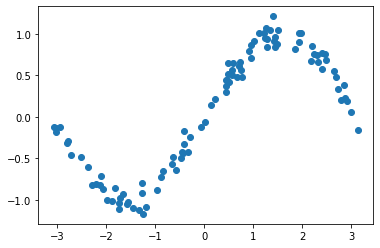

In [284]:
def get_sine_train_data():

    num_datapoints = 100
    noise = 1e-1

    x = np.random.uniform(low=-np.pi, high=np.pi, size=(num_datapoints,))
    y = np.sin(x) + np.random.normal(loc=0., scale=noise, size=(num_datapoints,))
    
    return x, y
    

x, y = get_sine_train_data()

plt.scatter(x, y)
plt.show()

In [285]:
class zero_mean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='eq_covariance'):
        
        super().__init__(name=name, dtype=dtype)
        
        
    def __call__(self, x):
        return tf.zeros(x.shape[0], dtype=self.dtype)

In [286]:
class eq_covariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (1, -1))

        assert log_scales.shape[-1] == dim,                \
            f'Expected the size of scales at axis 2 '    + \
            f'to be dim, found shapes {scales.shape} '   + \
            f'and {dim}.'

        assert log_coeff.shape == (),                     \
            f'Expected coeff to be a single scalar, '   + \
            f'found coeff.shape == {coeff.shape}.'
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
    
    @property
    def scales(self):
        return (10 ** self.log_scales) ** 2.
    
    
    @property
    def coeff(self):
        return (10 ** self.log_coeff) ** 2.
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag_only=False,
                 epsilon=None):
        
        # Reshape input tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Check dimensions are correct
        assert (tf.rank(x1) == tf.rank(x2) == 2) and       \
               (x1.shape[1] == x2.shape[1] == self.dim),   \
            f'Expected x1 and x2 to have 2 dimensions '  + \
            f'and to both match self.dim at second '     + \
            f'dimension, instead found shapes '          + \
            f'{x1.shape} and {x2.shape}.'

        scales = self.scales
        
        # If not calculating diagonal only, expand to broadcast
        if not diag_only:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, :, :]

        # Compute differences
        diffs = x1 - x2

        # Compute quadratic form
        quad = - 0.5 * diffs ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)

        # Exponentiate and multiply by covariance coeff
        exp_quad = tf.exp(quad)
        eq_cov = self.coeff ** 2 * exp_quad
        
        # Add epsilon for invertibility
        if epsilon is not None:
            
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], dtype=self.dtype)

        return eq_cov

In [287]:
dtype = tf.float64
log_coeff = 0.
log_scales = [0., 0.]

x1 = np.ones((3, 2))
x2 = np.ones((7, 2))

mean = zero_mean(dtype=dtype)

cov = eq_covariance(log_coeff=log_coeff,
                    log_scales=log_scales,
                    dim=2,
                    dtype=dtype)

print(mean(x1).shape, mean(x2).shape)

print(cov(x1, x2).shape, cov(x1, x1, diag_only=True).shape)

print(cov(x1, x1, diag_only=True))

(3,) (7,)
(3, 7) (3,)
tf.Tensor([1. 1. 1.], shape=(3,), dtype=float64)


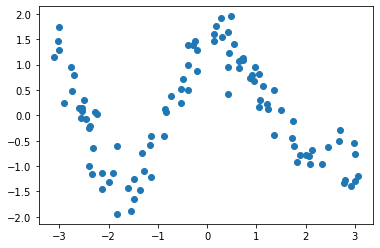

In [288]:
def get_gp_train_data():
    
    tf.random.set_seed(0)
    np.random.seed(0)
    
    num_datapoints = 100
    log_coeff = 0.
    log_noise = -2.
    log_scales = [0.]
    
    x = np.random.uniform(low=-np.pi, high=np.pi, size=(num_datapoints,))
    x = x[:, None]

    mean = zero_mean(dtype=dtype)
    mean = mean(x)

    cov = eq_covariance(log_coeff=log_coeff,
                        log_scales=log_scales,
                        dim=1,
                        dtype=dtype)
    cov = cov(x, x)
    cov = cov + tf.cast(tf.exp(log_noise), dtype=tf.float64) * tf.eye(cov.shape[0], dtype=tf.float64)

    normal = tfp.distributions.MultivariateNormalTriL
    normal = normal(loc=mean, scale_tril=tf.linalg.cholesky(cov))
    
    y = normal.sample()
    
    return x[:, 0], y
    

x, y = get_gp_train_data()

plt.scatter(x, y)
plt.show()

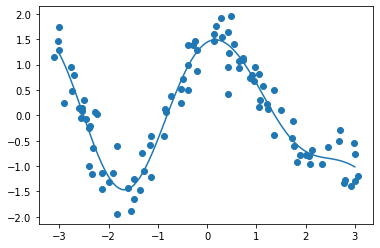

In [289]:
x_train, y_train = get_gp_train_data()

x_train = tf.convert_to_tensor(x_train, dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)

x_pred = tf.linspace(-3., 3., 100)
x_pred = tf.cast(x_pred, dtype=tf.float64)

cov = eq_covariance(log_coeff=0.,
                    log_scales=0.,
                    dim=1,
                    dtype=dtype)

K_xX = cov(x_pred[:, None], x_train[:, None])
K_Xx = cov(x_train[:, None], x_pred[:, None])
K_XX = cov(x_train[:, None], x_train[:, None], epsilon=1e-6)

X_XX_plus_noise = K_XX + 1e-2 * tf.eye(K_XX.shape[0], dtype = tf.float64)

y_pred = tf.einsum('ij, jk -> ik',
                   K_xX,
                   tf.linalg.solve(X_XX_plus_noise, y_train[:, None]))

plt.plot(x_pred, y_pred)
plt.scatter(x_train, y_train)

In [350]:
class SparseGP(tf.keras.Model):
    
    def __init__(self,
                 mean,
                 cov,
                 log_noise,
                 x_train,
                 y_train,
                 x_ind_init,
                 dtype,
                 name='sparse-gp',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
        
        # Set mean and covariance functions
        self.mean = mean
        self.cov = cov
    
        # Set log of noise parameter
        self.log_noise = tf.convert_to_tensor(log_noise,
                                              dtype=dtype)
        self.log_noise = tf.Variable(self.log_noise)
        
        # Set training data and inducing point initialisation
        self.x_train = tf.convert_to_tensor(x_train,
                                            dtype=dtype)
        
        self.y_train = tf.convert_to_tensor(y_train,
                                            dtype=dtype)
        
        self.x_ind = tf.convert_to_tensor(x_ind_init,
                                          dtype=dtype)
        self.x_ind = tf.Variable(self.x_ind)
        
        
        
    def post_pred(self, x_pred):
        
        # Compute D matrix (diagonal) plus noise
        D_diag_plus_noise = self.D_diag + self.noise
        
        # Compute Q matrix
        Q = self.Q
        
        # Covariance between prediction and inducing points
        K_pred_ind = self.cov(x_pred,
                              self.x_ind)
        
        K_ind_pred = tf.transpose(K_pred_ind, (1, 0))
        
        # Covariance between inducing and training points
        K_ind_train = self.cov(self.x_ind,
                               self.x_train)
        
        # Covariance between inducing and training points
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=1e-6)
        
        # Compute diagonal of covariance between prediction points
        K_pred_pred_diag = self.cov(x_pred,
                                    x_pred,
                                    diag_only=True)
        
        # Compute inversions to use one einsum at the end
        y_train_diff = self.y_train - self.mean(self.x_train)
        Q_inv_K_ind_train = tf.linalg.solve(Q, K_ind_train)
        D_diag_plus_noise_inv_y = (D_diag_plus_noise ** -1) * y_train_diff
        
        # Compute mean of posterior predictive
        mean = tf.einsum('ij, jk, k -> i',
                         K_pred_ind,
                         Q_inv_K_ind_train,
                         D_diag_plus_noise_inv_y)
        
        mean = mean + self.mean(x_pred)
        
        # Compute inversions
        K_ind_ind_inv_K_ind_pred = tf.linalg.solve(K_ind_ind, K_ind_pred)
        Q_inv_K_ind_pred = tf.linalg.solve(Q, K_ind_pred)
        
        diff_term = K_ind_ind_inv_K_ind_pred - Q_inv_K_ind_pred
        diff_term = tf.einsum('ij, ji -> i',
                              K_pred_ind,
                              diff_term)
        
        var = K_pred_pred_diag - diff_term + self.noise
        
        return mean, var
    
    
    @property
    def D_diag(self):
        
        # Covariance between training points (diagnal components)
        K_train_train = self.cov(self.x_train,
                                 self.x_train,
                                 diag_only=True)
        
        # Covariance between training and inducing points
        K_train_ind = self.cov(self.x_train,
                               self.x_ind)
        
        K_ind_train = tf.transpose(K_train_ind, (1, 0))
        
        # Covariance between inducing points
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=1e-12)
        
        K_ind_ind_inv_K_ind_train = tf.linalg.solve(K_ind_ind,
                                                    K_ind_train)
        
        # Compute diagonal D matrix
        A = K_train_train
        B = tf.einsum('nm, mn -> n',
                      K_train_ind,
                      K_ind_ind_inv_K_ind_train)
        
        D = A + B
        
        return D
    
    
    @property
    def noise(self):
        return (10 ** self.log_noise) ** 2
    
    
    @property
    def Q(self):
        
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind)
        
        K_train_ind = self.cov(self.x_train,
                               self.x_ind)
        
        D_diag = self.D_diag
        D_diag_plus_noise_inv = (D_diag + self.noise) ** -1
        
        Q = K_ind_ind
        Q = Q + tf.einsum('nm, n, nk -> mk',
                          K_train_ind,
                          D_diag_plus_noise_inv,
                          K_train_ind)
        
        return Q
    
        
    def log_evidence(self):
        
        K_ind_ind = self.cov(self.x_ind,
                             self.x_ind,
                             epsilon=1e-6)
        
        K_ind_train = self.cov(self.x_ind,
                               self.x_train)
        
        D_diag = self.D_diag
        
        chol = tf.linalg.cholesky(K_ind_ind)
        solved = tf.linalg.cholesky_solve(chol, K_ind_train)
        
        K = tf.einsum('ij, ik -> jk',
                      K_ind_train,
                      solved)
        
        K = K + self.noise * tf.eye(K.shape[0], dtype=self.dtype)
        K = K + tf.linalg.diag(D_diag)
        
        loc = self.mean(self.x_train)
        scale_tril = tf.linalg.cholesky(K)
        normal = tfp.distributions.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
        
        log_evidence = normal.log_prob(self.y_train)
        
        return log_evidence

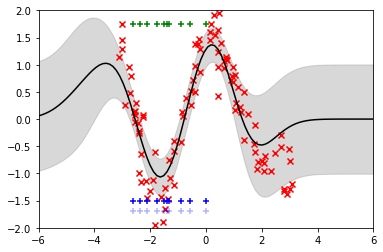

Log evidence: -137.65 Log coeff:  0.00 Log scales: [0.0] Log noise: -1.00


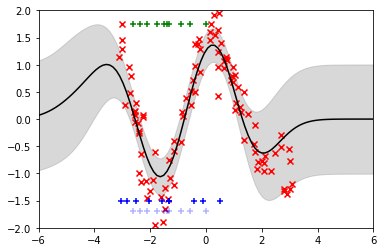

Log evidence: -137.57 Log coeff:  0.00 Log scales: [0.0] Log noise: -1.00


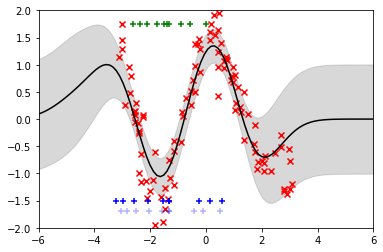

Log evidence: -137.55 Log coeff:  0.00 Log scales: [0.0] Log noise: -1.00


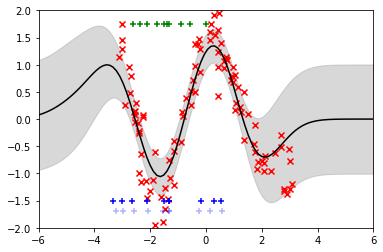

Log evidence: -137.55 Log coeff:  0.00 Log scales: [0.0] Log noise: -1.00


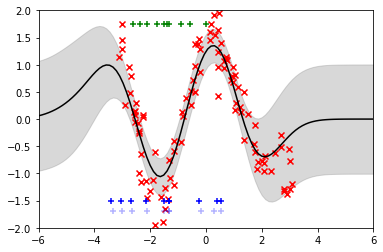

KeyboardInterrupt: 

In [351]:
dtype = tf.float64

num_inducing = 10
inducing_range = (-3., 0.)
log_noise = -1.
log_coeff = 0.
log_scales = [0.]
learn_rate = 1e-3

x_train, y_train = get_gp_train_data()

tf.random.set_seed(0)
uniform = tfp.distributions.Uniform(low=inducing_range[0],
                                    high=inducing_range[1])
x_ind_init = uniform.sample(sample_shape=(num_inducing, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

x_pred = tf.linspace(-6., 6., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

mean = zero_mean(dtype=dtype)

cov = eq_covariance(log_coeff=log_coeff,
                    log_scales=log_scales,
                    dim=1,
                    dtype=dtype)

sparse_gp = SparseGP(mean=mean,
                     cov=cov,
                     log_noise=log_noise,
                     x_train=x_train[:, None],
                     y_train=y_train,
                     x_ind_init=x_ind_init,
                     dtype=dtype)

optimizer = tf.keras.optimizers.Adam(learn_rate)

x_ind_prev = x_ind_init[:, 0].numpy()

for i in range(10000):
    
    if i % 500 == 0:
        
        if i > 0:
            print(f'Log evidence: {log_evidence.numpy():5.2f} '
                  f'Log coeff: {sparse_gp.cov.log_coeff.numpy():5.2f} '
                  f'Log scales: {[round(num[0], 3) for num in sparse_gp.cov.log_scales.numpy()]} '
                  f'Log noise: {sparse_gp.log_noise.numpy():5.2f}')
        
        mean, var = sparse_gp.post_pred(x_pred)

        x_pred_ = x_pred[:, 0].numpy()
        mean_ = mean.numpy()
        var_ = var.numpy()
        
        x_ind_curr = sparse_gp.x_ind[:, 0].numpy()

        plt.plot(x_pred_, mean_, color='black')
        plt.fill_between(x_pred_,
                         mean_ - var_ ** 0.5,
                         mean_ + var_ ** 0.5,
                         color='gray',
                         alpha=0.3)

        plt.scatter(x_train, y_train, color='red', marker='x')
        plt.scatter(x_ind_prev, -1.7 * tf.ones_like(x_ind_prev), color='blue', marker='+', alpha=0.3)
        plt.scatter(x_ind_curr, -1.5 * tf.ones_like(x_ind_curr), color='blue', marker='+')
        plt.scatter(x_ind_init, 1.75 * tf.ones_like(x_ind_init), color='green', marker='+')
        plt.xlim([-6., 6.])
        plt.ylim([-2, 2])
        plt.show()
        
        x_ind_prev = x_ind_curr
        
    
    with tf.GradientTape() as tape:

        log_evidence = sparse_gp.log_evidence()
        loss = - log_evidence

    gradients = tape.gradient(loss, [sparse_gp.x_ind])
    optimizer.apply_gradients(zip(gradients, [sparse_gp.x_ind]))

In [ ]:
def neg_log_evidence_value_and_gradient(sgp, x_ind_flat):
    
    sgp.x_ind.assign(tf.reshape(x_ind_flat, shape=(-1, 1)))

    with tf.GradientTape() as tape:
        
        log_evidence = sgp.log_evidence()
        loss = - log_evidence
        
    gradients = tf.reshape(tape.gradient(loss, [sgp.x_ind])[0], (-1,))
    
    return loss, gradients

In [ ]:
dtype = tf.float64

num_inducing = 10
inducing_range = (-3., -2.)
log_noise = -2.
log_coeff = 0.
log_scales = [0.]

x_train, y_train = get_gp_train_data()

uniform = tfp.distributions.Uniform(low=inducing_range[0],
                                    high=inducing_range[1])
x_ind_init = uniform.sample(sample_shape=(num_inducing, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

x_pred = tf.linspace(-6., 6., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

mean = zero_mean(dtype=dtype)

cov = eq_covariance(log_coeff=log_coeff,
                    log_scales=log_scales,
                    dim=1,
                    dtype=dtype)

sparse_gp = SparseGP(mean=mean,
                     cov=cov,
                     log_noise=log_noise,
                     x_train=x_train[:, None],
                     y_train=y_train,
                     x_ind_init=x_ind_init,
                     dtype=dtype)

x_ind_init = tf.reshape(x_ind_init, (-1,))

objective = lambda x_ind_flat : neg_log_evidence_value_and_gradient(sparse_gp, x_ind_flat)

optim_results = tfp.optimizer.lbfgs_minimize(objective,
                                             initial_position=x_ind_init,
                                             max_iterations=50)

In [310]:
optim_results.failed

<tf.Tensor: shape=(), dtype=bool, numpy=True>

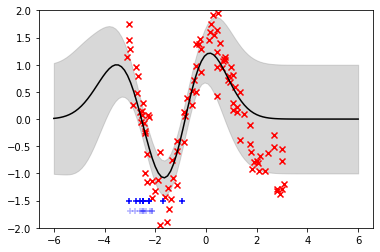

In [311]:
sparse_gp.x_ind = tf.reshape(optim_results.position, (-1, 1))

mean, var = sparse_gp.post_pred(x_pred)

x_pred_ = x_pred[:, 0].numpy()
mean_ = mean.numpy()
var_ = var.numpy()

x_ind_curr = sparse_gp.x_ind[:, 0].numpy()

plt.plot(x_pred_, mean_, color='black')
plt.fill_between(x_pred_,
                 mean_ - var_ ** 0.5,
                 mean_ + var_ ** 0.5,
                 color='gray',
                 alpha=0.3)

plt.scatter(x_train, y_train, color='red', marker='x')
plt.scatter(x_ind_init, -1.7 * tf.ones_like(x_ind_init), color='blue', marker='+', alpha=0.3)
plt.scatter(x_ind_curr, -1.5 * tf.ones_like(x_ind_curr), color='blue', marker='+')
plt.ylim([-2, 2])
plt.show()

In [346]:
def plot(model, title=""):
    
    x_pred = tf.linspace(-6., 6., 100)[:, None]
    x_pred = tf.cast(x_pred, dtype=tf.float64)
    
    model.x_ind = tf.reshape(optim_results.position, (-1, 1))

    mean, var = model.predict_y(x_pred)

    x_pred_ = x_pred[:, 0].numpy()
    mean_ = mean[:, 0].numpy()
    var_ = var[:, 0].numpy()

    x_ind_curr = model.inducing_variable.Z.numpy()

    plt.plot(x_pred_, mean_, color='black')
    plt.fill_between(x_pred_,
                     mean_ - var_ ** 0.5,
                     mean_ + var_ ** 0.5,
                     color='gray',
                     alpha=0.3)

    plt.scatter(x_train, y_train, color='red', marker='x')
    plt.scatter(x_ind_curr, -1.5 * tf.ones_like(x_ind_curr), color='blue', marker='+')
    plt.ylim([-2, 2])
    plt.show()

Before optimisation
<tf.Variable 'Variable:0' shape=(10, 1) dtype=float64, numpy=
array([[-3.41604972],
       [-3.58686709],
       [-2.92921853],
       [-2.87748504],
       [-3.16665101],
       [-2.3843441 ],
       [-3.0135498 ],
       [-2.0037415 ],
       [-2.60652971],
       [-3.7492528 ]])>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.2521789694259944>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
0


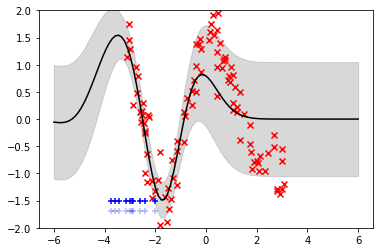

1000


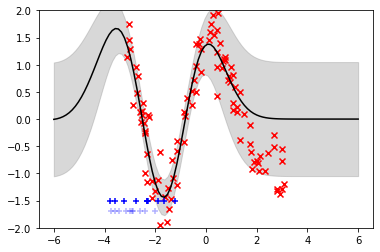

2000


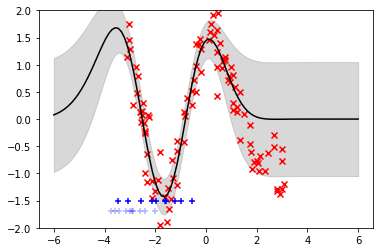

3000


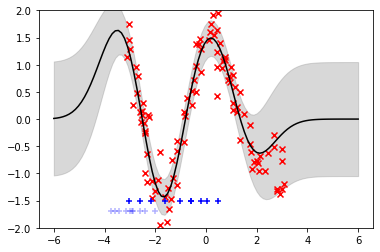

4000


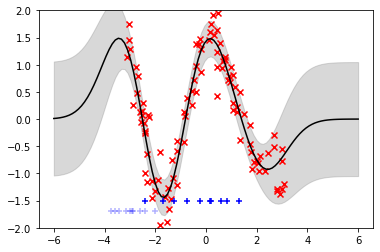

5000


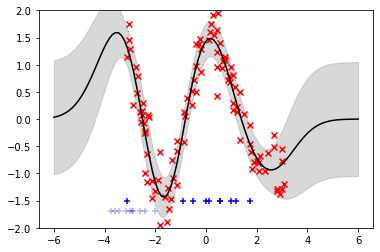

6000


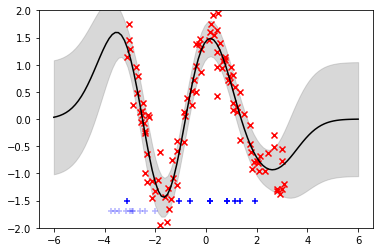

7000


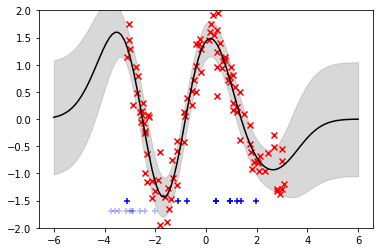

8000


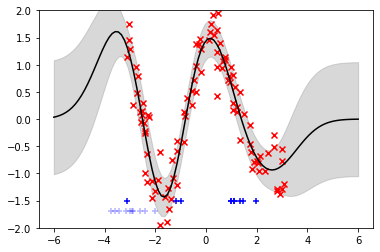

9000


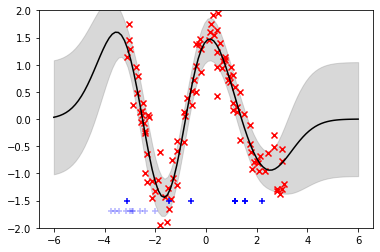

10000


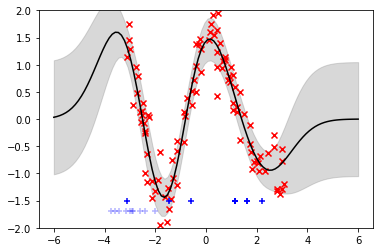

After optimisation
<tf.Variable 'Variable:0' shape=(10, 1) dtype=float64, numpy=
array([[-0.58411787],
       [-1.44769618],
       [ 1.14019873],
       [ 1.14004184],
       [ 1.14011874],
       [ 1.61479537],
       [ 1.14016835],
       [ 2.20854172],
       [ 1.6147956 ],
       [-3.09993835]])>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.2521789694259944>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>


In [347]:
dtype = tf.float64

inducing_range = (-4., -2.)

x_train, y_train = get_gp_train_data()

tf.random.set_seed(0)
uniform = tfp.distributions.Uniform(low=inducing_range[0],
                                    high=inducing_range[1])
x_ind_init = uniform.sample(sample_shape=(num_inducing, 1))
x_ind_init = tf.cast(x_ind_init, dtype=dtype)

kernel = gpf.kernels.SquaredExponential(variance=1., lengthscales=1.)

fitc = gpf.models.GPRFITC([x_train[:, None],y_train[:, None]], 
                          kernel=kernel, 
                          inducing_variable=x_ind_init,
                          noise_variance=1e-1)

print('Before optimisation')
for var in fitc.trainable_variables: print(var)
for var in kernel.trainable_variables: print(var)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
    
def optimization_step(model):
    
    with tf.GradientTape() as tape:

        log_evidence = model.maximum_log_likelihood_objective()
        loss = - log_evidence

    gradients = tape.gradient(loss, fitc.trainable_variables[:1])
    optimizer.apply_gradients(zip(gradients, fitc.trainable_variables[:1]))

    
for step in range(10001):
    if step % 1000 == 0:
        print(step)
        plot(fitc)
    optimization_step(fitc)
    
print('After optimisation')
for var in fitc.trainable_variables: print(var)
for var in kernel.trainable_variables: print(var)

# Generative process

In [277]:
num_inducing = 10

tf.random.set_seed(0)
uniform = tfp.distributions.Uniform(low=inducing_range[0],
                                    high=inducing_range[1])
x_ind = uniform.sample(sample_shape=(num_inducing, 1))
x_ind = tf.cast(x_ind, dtype=dtype)

mean = zero_mean(dtype=dtype)

cov = eq_covariance(log_coeff=log_coeff,
                    log_scales=log_scales,
                    dim=1,
                    dtype=dtype)

prior_normal = tfp.distributions.MultivariateNormalFullCovariance
prior_normal = evidence_normal(loc=mean(self.x_train),
                               covariance_matrix=cov(x_ind, x_ind))

prior_normal.sample().shape

NameError: name 'evidence_normal' is not defined